##

## Workshop Day 2

In [2]:

# Dependencies (pay attention to tf version)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from util import *

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

print(tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

2.16.1


# Part 1: Extract data

Extract data of person walking with exoskeleton.
For the purpose of this second experiment we will only observe Walking (both in transparent mode and in State Machine mode).

We create two different df, one for SM one for transparent

In [3]:
df_list = []

# Iterate over all files in the directory
for filename in os.listdir("../data/"):
    if filename.endswith('_ml_dataset_extracted.csv'):
        # Construct full file path
        file_path = os.path.join("../data/", filename)
        # Read CSV file into DataFrame
        df = pd.read_csv(file_path, index_col=0)
        # Append DataFrame to list
        df_list.append(df)

# Concatenate all DataFrames in the list
df = pd.concat(df_list, ignore_index=True)

df_Transparent = df[(df['condition'] == 'transparent_WALKING')& df.step_complete_r]
df_StateMachine = df[(df['condition'] == 'SM_WALKING') & df.step_complete_r]


In [4]:
def segment_stride(stance_interpolate_factor, joint, segment_length=100):
    """
    Segments gait using stance interpolation factor

    """
    segments_alpha = []
    segments_theta = []
    start_index = 0
    completed_gait = False

    for i in range(1, len(stance_interpolate_factor)):
        if stance_interpolate_factor[i] == 1:
            completed_gait = True
        elif completed_gait and stance_interpolate_factor[i] == 0:
            segments_alpha.append(stance_interpolate_factor[start_index:i])
            segments_theta.append(joint[start_index:i])
            start_index = i
            completed_gait = False


    gait_phases =[]
    segments_alpha_2 = []
    segments_theta_2 = []
    for segment_al, segment_th in zip(segments_alpha, segments_theta):
        x = np.linspace(0, 100, len(segment_al))
        gait_phases.append(x)
        segments_alpha_2.append(segment_al)
        segments_theta_2.append(segment_th)

    return segments_alpha_2, segments_theta_2, gait_phases


In [5]:
# transparent
segmented_joints_transparent ={0:[], 1: [], 2:[], 3:[]}
segmented_velocity_transparent ={0:[], 1: [], 2:[], 3:[]}
segmented_joints_SM= {0:[], 1: [], 2:[], 3:[]}
segmented_velocity_SM= {0:[], 1: [], 2:[], 3:[]}
for i in range(4):
    segmented_alpha_transparent, segmented_joints_transparent[i], gait_phase_transparent = segment_stride( df_Transparent[' StanceInterpolationFactor'].to_numpy(), df_Transparent[' JointPositions_'+str(i+1)].to_numpy())
    _, segmented_velocity_transparent[i], _ = segment_stride( df_Transparent[' StanceInterpolationFactor'].to_numpy(), df_Transparent[' JointVelocities_'+str(i+1)].to_numpy())
    
    segmented_alpha_SM, segmented_joints_SM[i], gait_phase_SM = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), df_StateMachine[' JointPositions_'+str(i+1)].to_numpy())
    _, segmented_velocity_SM[i], _ = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), df_StateMachine[' JointVelocities_'+str(i+1)].to_numpy())

N_STEPS_TRANSPARENT = len(segmented_alpha_transparent)
N_STEPS_SM = len(segmented_alpha_SM)
print("Number steps in transparent:",N_STEPS_TRANSPARENT, "Number steps in SM: ", N_STEPS_SM)

Number steps in transparent: 254 Number steps in SM:  254


Concatenate all steps

In [6]:
segmented_alpha_transparent = np.concatenate(segmented_alpha_transparent)
gait_phase_transparent = np.concatenate(gait_phase_transparent)
segmented_alpha_SM = np.concatenate(segmented_alpha_SM)
gait_phase_SM = np.concatenate(gait_phase_SM)

for i in range(4):
      segmented_joints_transparent[i] = np.concatenate(segmented_joints_transparent[i])
      segmented_velocity_transparent[i] = np.concatenate(segmented_velocity_transparent[i])
      segmented_joints_SM[i] = np.concatenate(segmented_joints_SM[i])
      segmented_velocity_SM[i] = np.concatenate(segmented_velocity_SM[i])

print(segmented_alpha_transparent.shape, segmented_joints_transparent[0].shape, segmented_joints_transparent[1].shape, segmented_joints_transparent[2].shape,
      segmented_joints_transparent[3].shape, gait_phase_transparent.shape)
print(segmented_alpha_SM.shape, segmented_joints_SM[0].shape, segmented_joints_SM[1].shape,
      segmented_joints_SM[2].shape, segmented_joints_SM[3].shape, gait_phase_SM.shape)

(307875,) (307875,) (307875,) (307875,) (307875,) (307875,)
(244944,) (244944,) (244944,) (244944,) (244944,) (244944,)


Plot steps (with mean and variance)

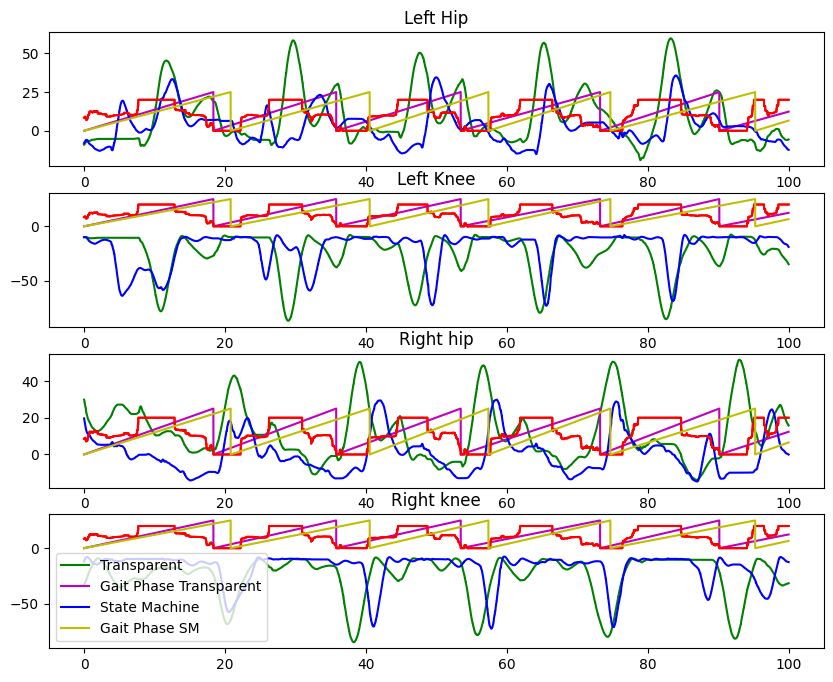

In [101]:
fig, axs = plt.subplots(4, figsize=(10, 8))
axs[0].set_title('Left Hip')
axs[1].set_title('Left Knee')
axs[2].set_title('Right hip')
axs[3].set_title('Right knee')

#transparent
for i in range(4):
    axs[i].plot(np.linspace(0, 100, 10000), (segmented_joints_transparent[i][:10000])*180/np.pi, 'g-', label= "Transparent")
    axs[i].plot(np.linspace(0, 100, 10000),  segmented_alpha_transparent[:10000]*20, 'r-')
    axs[i].plot(np.linspace(0, 100, 10000), gait_phase_transparent[:10000]/4, 'm-', label = "Gait Phase Transparent")

    # STate machine
    axs[i].plot(np.linspace(0, 100, 10000), segmented_joints_SM[i][:10000]*180/np.pi, 'b-', label= "State Machine")
    axs[i].plot(np.linspace(0, 100, 10000), segmented_alpha_transparent[:10000]*20, 'r-')
    axs[i].plot(np.linspace(0, 100, 10000), gait_phase_SM[:10000]/4, 'y-', label = "Gait Phase SM")

plt.legend()
plt.show()

# Part 2: Regression of the gait phase


**Exercice 2** Build Neural Network that receives as input the kinematics and the stance interpolation factor and returns as output the gait phase (x coordidinate previous plot)

We will build two models: one trained using transparent data, one using SM data and we will compare their performance on two validation sets (one SM one transparent). 



### Prepare Input / output data

<div>
<img src="imgs/data_CNN.jpg" width="300"/>
</div>

**Inputs:** The model had a data input size of 10 channel values (joint position/velocity) for every time step of 5 ms with a window size of 80 data samples. All input and output data is normalized (subtract mean and divide by std)


In [7]:
# concatenate joint angles and steps
input_transparent= np.array([segmented_joints_transparent[0],
                    segmented_joints_transparent[1],
                    segmented_joints_transparent[2],
                    segmented_joints_transparent[3]])
# concatenate to input the joint velocity
joint_velocity = np.array([segmented_velocity_transparent[0],
                    segmented_velocity_transparent[1],
                    segmented_velocity_transparent[2],
                    segmented_velocity_transparent[3]])
input_transparent = np.concatenate((input_transparent, joint_velocity, [segmented_alpha_transparent]), 0)

# normalize input data
mean= np.mean(input_transparent, 1)[:, np.newaxis]
std = np.std(input_transparent, 1)[:, np.newaxis]
input_transparent= (input_transparent - mean) / std
print("Transparent")
print("Input Shape ", input_transparent.shape)
print("input mean: ", mean.transpose())
print("input std: ", std.transpose())

# concatenate joint angles and steps
input_SM= np.array([segmented_joints_SM[0],
                    segmented_joints_SM[1],
                    segmented_joints_SM[2],
                    segmented_joints_SM[3]])
# concatenate to input the joint velocity
joint_velocity = np.array([segmented_velocity_SM[0],
                    segmented_velocity_SM[1],
                    segmented_velocity_SM[2],
                    segmented_velocity_SM[3]])
input_SM = np.concatenate((input_SM, joint_velocity, [segmented_alpha_SM]), 0)

# normalize input data
mean= np.mean(input_SM, 1)[:, np.newaxis]
std = np.std(input_SM, 1)[:, np.newaxis]
input_SM= (input_SM - mean) / std
print("State Machine")
print("Input Shape ", input_SM.shape)
print("input mean: ", mean.transpose())
print("input std: ", std.transpose())


Transparent
Input Shape  (9, 307875)
input mean:  [[ 0.1070395  -0.41812929  0.12483035 -0.42795709  0.00263583  0.00088095
   0.0021914  -0.00558785  0.52387591]]
input std:  [[0.30352596 0.32768005 0.25979393 0.31698237 0.85880445 0.90201861
  0.71886319 0.8557047  0.42288404]]
State Machine
Input Shape  (9, 244944)
input mean:  [[ 0.01863269 -0.38251228  0.01726579 -0.37776941  0.00228569 -0.00354917
   0.00166179 -0.00550041  0.51572936]]
input std:  [[0.22638984 0.32521091 0.22196548 0.3148126  0.80184016 1.40850296
  0.75892327 1.36970231 0.41097477]]


Prepare Output

In [8]:
output_transparent = np.array(gait_phase_transparent)/100.0 # created normalized
print("Output transparent shape ", output_transparent.shape)

output_SM = gait_phase_SM/100.0 # created normalized
print("Output SM shape ", output_SM.shape)

Output transparent shape  (307875,)
Output SM shape  (244944,)


Divide data in time windows: save one value every 5ms, since data is recorded with a frequency of 333Hz the data must be reshaped to have a frequency of 200Hz

In [4]:
import scipy.signal as signal

def divide_time_windows(input, output, window_length, step):
    divided_input = []
    divided_output = []

    # downsampling
    ORIGINAL_FREQUENCY = 333 #Hz
    DESIRED_FREQUENCY = 200
    num_samples = int(input.shape[1] * DESIRED_FREQUENCY / ORIGINAL_FREQUENCY)

    input = signal.resample(input, num_samples, axis=1)
    output = signal.resample(output, num_samples)
    output[output > 1] = 1
    output[output < 0] = 0

    # divide in window
    for i in range(window_length, input.shape[1], step):
        divided_input.append(input[:, i-window_length: i])
        divided_output.append(output[i])

    return np.array(divided_input), np.array(divided_output)

In [10]:
WINDOW_LENGTH = 80 #check frequency
STEP = 3
input_transparent, output_transparent = divide_time_windows(input_transparent, output_transparent, WINDOW_LENGTH, STEP)
print("Data transparent Shape: ", input_transparent.shape, output_transparent.shape)

input_SM, output_SM = divide_time_windows(input_SM, output_SM, WINDOW_LENGTH, STEP)
print("Data SM Shape: ", input_SM.shape, output_SM.shape)

Data transparent Shape:  (61610, 9, 80) (61610,)
Data SM Shape:  (49011, 9, 80) (49011,)


Divide training set and output set in training and validation set (70%, 30%).

In [11]:
train_input_transparent = np.swapaxes(input_transparent[:int(input_transparent.shape[0]*0.7), :, :], 1, 2)
train_output_transparent = output_transparent[:int(input_transparent.shape[0]*0.7)]
val_input_transparent =  np.swapaxes(input_transparent[int(input_transparent.shape[0]*0.7):, :, :], 1, 2)
val_output_transparent = output_transparent[int(input_transparent.shape[0]*0.7):]

print("Transparent ")
print("Training set shape: ", train_input_transparent.shape, train_output_transparent.shape)
print("Validation set shape: ", val_input_transparent.shape, val_output_transparent.shape)

train_input_SM = np.swapaxes(input_SM[:int(input_SM.shape[0]*0.7), :, :], 1, 2)
train_output_SM = output_SM[:int(input_SM.shape[0]*0.7)]
val_input_SM =  np.swapaxes(input_SM[int(input_SM.shape[0]*0.7):, :, :], 1, 2)
val_output_SM = output_SM[int(input_SM.shape[0]*0.7):]

print("State Machine")
print("Training set shape: ", train_input_SM.shape, train_output_SM.shape)
print("Validation set shape: ", val_input_SM.shape, val_output_SM.shape)

Transparent 
Training set shape:  (43127, 80, 9) (43127,)
Validation set shape:  (18483, 80, 9) (18483,)
State Machine
Training set shape:  (34307, 80, 9) (34307,)
Validation set shape:  (14704, 80, 9) (14704,)


### Create Model:

<div>
<img src="imgs/models.jpg" width="700"/>
</div>

The model had a data input size of 10 channel values (left/right hip position/velocity and trunk IMU) for every
time step of 5 ms with a window size of 80 data samples (Fig. 3). The first layer consisted of a batch normalization, where the
input values were normalized to a zero mean and unit variance. The second layer consisted of a 1D convolution of 10 filters
striding temporally, where each filter had a kernel size of 20. The third layer was another 1D convolution of 10 filters, where
each filter had a kernel size of the previous layer’s window size and compressed the data into a single row vector (representing
the extracted feature information). A sigmoid activation function was applied to this vector and passed the data to a fully connected
dense layer with a tanh activation function.

In [12]:
model_transparent = models.Sequential()
#model.add(layers.BatchNormalization(input_shape=(80,9)))
model_transparent.add(layers.GaussianNoise(0.01, input_shape=(80,9)))
model_transparent.add(layers.Conv1D(10, 20, activation = 'relu'))
model_transparent.add(layers.Conv1D(10, 61, activation = 'sigmoid'))
model_transparent.add(layers.Flatten())
model_transparent.add(layers.Dense(20, activation = 'relu'))
model_transparent.add(layers.Dense(10, activation = 'relu'))
model_transparent.add(layers.Dense(2, activation='tanh'))

model_transparent.summary()

model_SM = models.Sequential()
#model.add(layers.BatchNormalization(input_shape=(80,9)))
model_SM.add(layers.GaussianNoise(0.01, input_shape=(80,9)))
model_SM.add(layers.Conv1D(10, 20, activation = 'relu'))
model_SM.add(layers.Conv1D(10, 61, activation = 'sigmoid'))
model_SM.add(layers.Flatten())
model_SM.add(layers.Dense(20, activation = 'relu'))
model_SM.add(layers.Dense(10, activation = 'relu'))
model_SM.add(layers.Dense(2, activation='tanh'))

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 80, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 61, 10)         │         1,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 10)          │         6,110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,372 (32.70 KB)

 Trainable params: 8,372 (32.70 KB)

 Non-trainable params: 0 (0.00 B)

**Loss function:** To ensure that the gait phase error was evaluated accurately during the transition from one gait cycle to the next, where 100 and 0 represent the same value, we used an angular similarity metric by computing the cosine distance between the predicted and the ground truth Cartesian coordinates. The root mean square error (RMSE) of each stride was then computed as the percentage representation of the root mean square of the angular similarity
metric over the gait cycle.

In [13]:
def loss_function(y_true, y_pred):
    gait_phase_cos_error = tf.sqrt(tf.reduce_mean(tf.square(y_pred[:, 0] - tf.cos(y_true*2*np.pi))))
    gait_phase_sin_error = tf.sqrt(tf.reduce_mean(tf.square(y_pred[:, 1] - tf.sin(y_true*2*np.pi))))
    return gait_phase_cos_error + gait_phase_sin_error


### Train the two models

**Training:** The CNN was trained using a stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 and a batch size of 128, 

In [14]:
optimizer_transparent = tf.keras.optimizers.Adam(learning_rate=0.001)

model_transparent.compile(loss=loss_function,
          optimizer=optimizer_transparent,
          metrics=['accuracy'])

history = model_transparent.fit(train_input_transparent, train_output_transparent, epochs=1,
                    validation_data=(val_input_transparent, val_output_transparent))


1348/1348 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0052 - loss: 0.6464 - val_accuracy: 0.0052 - val_loss: 0.4478


In [15]:
optimizer_SM = tf.keras.optimizers.Adam(learning_rate=0.001)

model_SM.compile(loss=loss_function,
          optimizer=optimizer_SM,
          metrics=['accuracy'])

history = model_SM.fit(train_input_SM, train_output_SM, epochs=1,
                    validation_data=(val_input_SM, val_output_SM))

1073/1073 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0051 - loss: 0.7850 - val_accuracy: 0.0060 - val_loss: 0.5202


### Validation models

Validate the two models with the two validation sets to evaluate the generalization ability, 4 combinations:
- Model trained with transparent data <--> tested on transparent data
- Model trained with transparent data <--> tested on SM data
- Model trained with SM data <--> tested on transparent data
- Model trained with SM data <--> tested on SM data

In [16]:
y_pred_trans_trans = model_transparent.predict(val_input_transparent)
y_pred_trans_SM = model_transparent.predict(val_input_SM)
y_pred_SM_SM = model_SM.predict(val_input_SM)
y_pred_SM_trans = model_SM.predict(val_input_transparent)

578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [17]:
def transform_output(y_pred):
    return (np.arctan2(y_pred[:, 1]*2*np.pi, y_pred[:, 0]*2*np.pi) % (2 * np.pi)) /(2*np.pi)

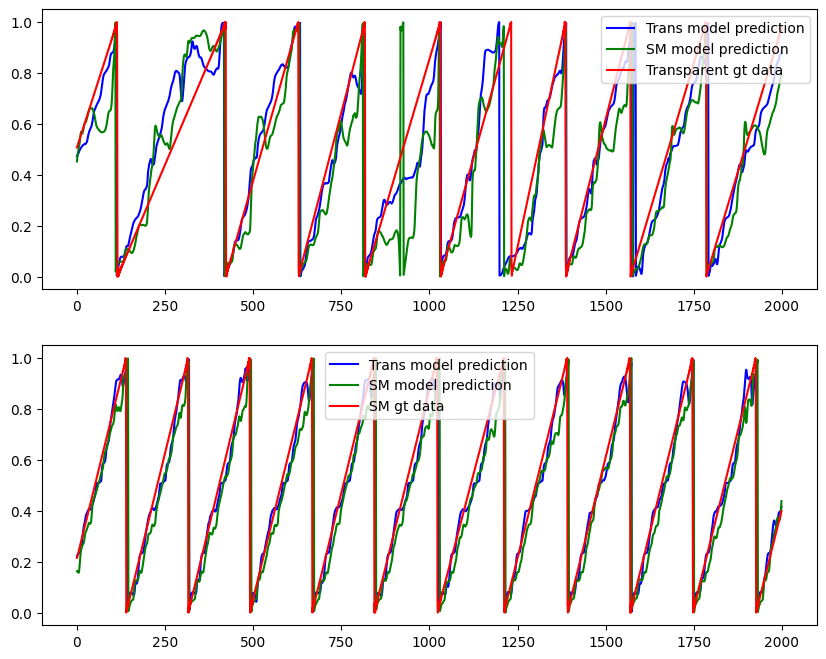

In [18]:

fig, axs = plt.subplots(2, figsize=(10, 8))
axs[0].plot(transform_output(y_pred_trans_trans[:2000]), color="b",  label = "Trans model prediction")
axs[0].plot(transform_output(y_pred_SM_trans[:2000]), color="g", label = "SM model prediction")
axs[0].plot(val_output_transparent[:2000], color='r', label="Transparent gt data")
axs[0].legend()

axs[1].plot(transform_output(y_pred_trans_SM[:2000]), color= "b", label = "Trans model prediction")
axs[1].plot(transform_output(y_pred_SM_SM[:2000]), color ="g", label = "SM model prediction")
axs[1].plot(val_output_SM[:2000], color='r',  label="SM gt data")

axs[1].legend()
plt.show()

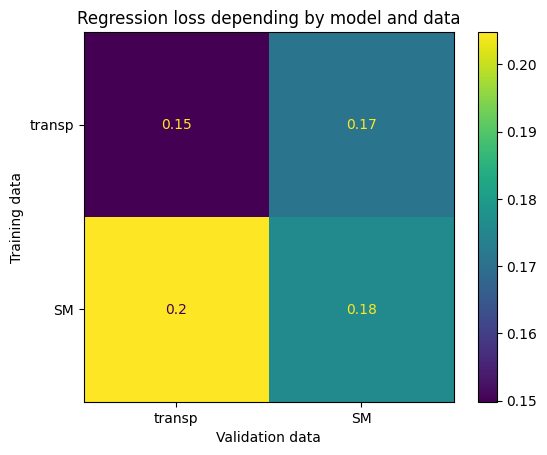

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

trans_trans_error = np.sqrt(np.mean(np.square(transform_output(y_pred_trans_trans) - val_output_transparent)))
trans_SM_error = np.sqrt(np.mean(np.square(transform_output(y_pred_trans_SM) - val_output_SM)))
SM_trans_error = np.sqrt(np.mean(np.square(transform_output(y_pred_SM_trans) - val_output_transparent)))
SM_SM_error = np.sqrt(np.mean(np.square(transform_output(y_pred_SM_SM) - val_output_SM)))

confusion_matrix = np.array([[trans_trans_error, trans_SM_error],
                             [SM_trans_error, SM_SM_error]])

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["transp", "SM"])
disp.plot(ax=ax, cmap='viridis')
plt.xlabel('Validation data')
plt.ylabel('Training data')
plt.title("Regression loss depending by model and data")
plt.show()

Save model

In [184]:
import keras

model_transparent.export("../models/transparent/")
model_SM.export("../models/SM/")


INFO:tensorflow:Assets written to: ../models/transparent/assets


INFO:tensorflow:Assets written to: ../models/transparent/assets


Saved artifact at '../models/transparent/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 9), dtype=tf.float32, name='keras_tensor_290')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2248726965488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2247405890272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2248736734224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2248736722432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249369122800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2248730778032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2248730777504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249458918752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249458915936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249458921744: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: ../models/SM/assets


Saved artifact at '../models/SM/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 9), dtype=tf.float32, name='keras_tensor_319')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2249426054384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249426050160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249426046816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249426047520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249464313312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249464306624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249464302048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249464300640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249464300288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249464309792: TensorSpec(shape=(), dtype=tf.resource, name=None)


Send the two created models as zip file with the following format: *transparent(SM)_groupNumber* at the following email adress: lollo.vianello95@gmail.com

# Part 3: Test on robot

# Part 4 (?): Locomotion mode classification
- transparent_WALKING, SM_WALKING --> 1
- SM_RAMPS_DOWN, transparent_RAMPS_DOWN --> 3
- SM_RAMPS_UP, transparent_RAMPS_UP --> 2
- SM_STAIRS_UP, transparent_STAIRS_UP --> 4
- SM_STAIRS_DOWN, transparent_STAIRS_DOWN --> 5


In [5]:
df_locomotion_modes = df[df.step_complete_r]
print(np.unique(df_locomotion_modes['condition']))
print(np.unique(df_locomotion_modes['condition_encoded']))
CLASSES = ["Walking", "Ramp\nAsc", "Ramp\nDesc", "Stairs\nAsc", "Stair\nDesc"]

['SM_RAMPS_DOWN' 'SM_RAMPS_UP' 'SM_STAIRS_DOWN' 'SM_STAIRS_UP'
 'SM_WALKING' 'transparent_RAMPS_DOWN' 'transparent_RAMPS_UP'
 'transparent_STAIRS_DOWN' 'transparent_STAIRS_UP' 'transparent_WALKING']
[1 2 3 4 5]


Plot conditions over time 

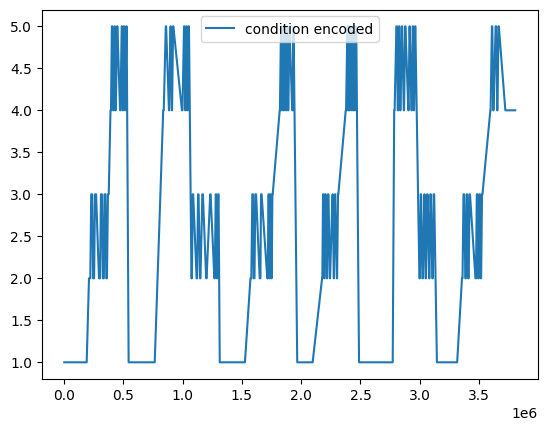

In [6]:
plt.plot(df_locomotion_modes['condition_encoded'], label = "condition encoded")
plt.legend()
plt.show()

Prepare dataset (input same as before, joint position and velocity, stance interpol), output the 5 classes

In [25]:
# concatenate joint angles and steps
joint_position_lm= np.array([df_locomotion_modes[' JointPositions_1'],
                    df_locomotion_modes[' JointPositions_2'],
                    df_locomotion_modes[' JointPositions_3'],
                    df_locomotion_modes[' JointPositions_4']])
# concatenate to input the joint velocity
joint_velocity_lm = np.array([df_locomotion_modes[' JointVelocities_1'],
                    df_locomotion_modes[' JointVelocities_2'],
                    df_locomotion_modes[' JointVelocities_3'],
                    df_locomotion_modes[' JointVelocities_4']])
input_lm = np.concatenate((joint_position_lm, joint_velocity_lm, [df_locomotion_modes[' StanceInterpolationFactor']]), 0)

# normalize input data
mean= np.mean(input_lm, 1)[:, np.newaxis]
std = np.std(input_lm, 1)[:, np.newaxis]
input_lm= (input_lm - mean) / std
print("Input Shape ", input_lm.shape)
print("input mean: ", mean.transpose())
print("input std: ", std.transpose())

output_lm = np.array(np.eye(5)[df_locomotion_modes['condition_encoded']- 1]) # created normalized and convert to categorical output
print("Output locomotion mode classification shape ", output_lm.shape)


WINDOW_LENGTH = 80 #check frequency
STEP = 3
input_lm, output_lm = divide_time_windows(input_lm, output_lm, WINDOW_LENGTH, STEP)
print("Data Shape: ", input_lm.shape, output_lm.shape)


train_input_lm = np.swapaxes(input_lm[:int(input_lm.shape[0]*0.7), :, :], 1, 2)
train_output_lm = output_lm[:int(input_lm.shape[0]*0.7)]
val_input_lm =  np.swapaxes(input_lm[int(input_lm.shape[0]*0.7):, :, :], 1, 2)
val_output_lm = output_lm[int(input_lm.shape[0]*0.7):]

print("Training set shape: ", train_input_lm.shape, train_output_lm.shape)
print("Validation set shape: ", val_input_lm.shape, val_output_lm.shape)

Input Shape  (9, 1155946)
input mean:  [[ 0.11250332 -0.51188302  0.12553347 -0.52522516  0.00096523  0.00318148
   0.00192878 -0.0041749   0.51679545]]
input std:  [[0.33812103 0.42814785 0.31071239 0.42433421 0.88573358 1.24113099
  0.79597748 1.21673425 0.42034017]]
Output locomotion mode classification shape  (1155946, 5)
Data Shape:  (231394, 9, 80) (231394, 5)
Training set shape:  (161975, 80, 9) (161975, 5)
Validation set shape:  (69419, 80, 9) (69419, 5)


**Exercice** Create the model (similar to the previous one but this time remember that the output must be categorical (value 0 or 1) and should have 5 dimensions), some suggestions:
- suggested activation function :softmax
- as loss function a common one is CategoricalCrossentropy


In [26]:
model_lm = models.Sequential()
model_lm.add(layers.GaussianNoise(0.01, input_shape=(80,9)))
model_lm.add(layers.Conv1D(10, 20, activation = 'relu'))
model_lm.add(layers.Conv1D(10, 61, activation = 'sigmoid'))
model_lm.add(layers.Flatten())
model_lm.add(layers.Dense(20, activation = 'relu'))
model_lm.add(layers.Dense(10, activation = 'relu'))
model_lm.add(layers.Dense(5, activation='softmax'))

#model_lm.summary()

optimizer_lm = tf.keras.optimizers.Adam(learning_rate=0.001)

model_lm.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
          optimizer=optimizer_lm,
          metrics=['accuracy'])

history = model_lm.fit(train_input_lm, train_output_lm, epochs=15,
                    validation_data=(val_input_lm, val_output_lm))


C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - accuracy: 0.7275 - loss: 0.7162 - val_accuracy: 0.7707 - val_loss: 0.7351
Epoch 2/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8346 - loss: 0.4526 - val_accuracy: 0.7609 - val_loss: 0.7885
Epoch 3/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.8424 - loss: 0.4327 - val_accuracy: 0.7712 - val_loss: 0.7375
Epoch 4/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.8480 - loss: 0.4204 - val_accuracy: 0.7573 - val_loss: 0.8235
Epoch 5/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.8545 - loss: 0.4090 - val_accuracy: 0.7536 - val_loss: 0.8135
Epoch 6/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.8541 - loss: 0.4031 - val_accuracy: 0.7759 - val_loss: 0.7811
Epoch 7/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.8573 - loss: 0.4014 - val_accuracy: 0.7480 - val_loss: 0.8276
Epoch 8/15
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.8549 - loss: 0

Predict validation set for evaluation of the model

In [23]:
predicted_values = model_lm.predict(val_input_lm)


2170/2170 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Plot prediction probability (between 0 and 1) and max values

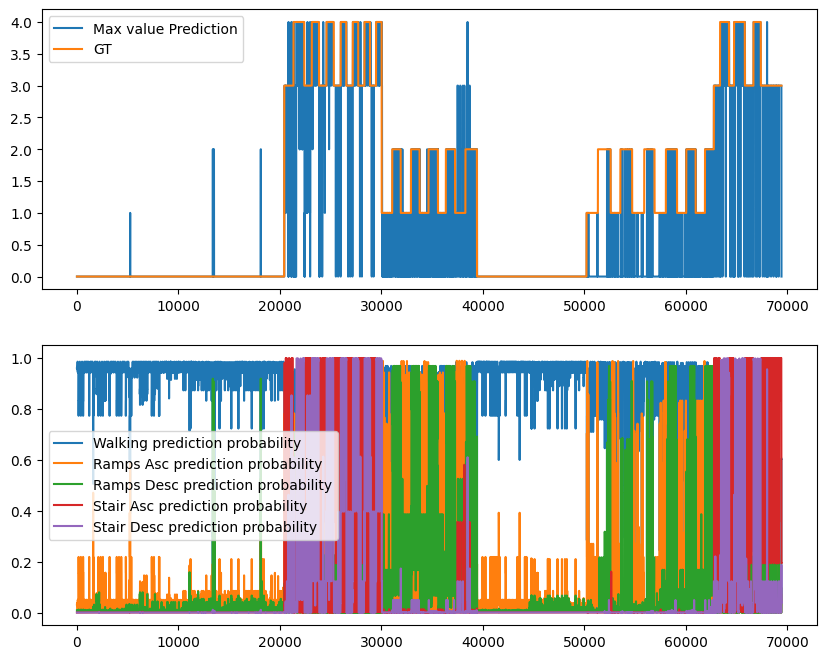

In [24]:
fig, axs = plt.subplots(2, figsize=(10, 8))

axs[1].plot(predicted_values[:, 0], label= "Walking prediction probability")
axs[1].plot(predicted_values[:, 1], label= "Ramps Asc prediction probability")
axs[1].plot(predicted_values[:, 2], label= "Ramps Desc prediction probability")
axs[1].plot(predicted_values[:, 3], label= "Stair Asc prediction probability")
axs[1].plot(predicted_values[:, 4], label= "Stair Desc prediction probability")

axs[0].plot(np.argmax(predicted_values, 1), label= "Max value Prediction")
axs[0].plot(np.argmax(val_output_lm, 1), label= "GT")

axs[0].legend()
axs[1].legend()
plt.legend()

Display confusion matrix

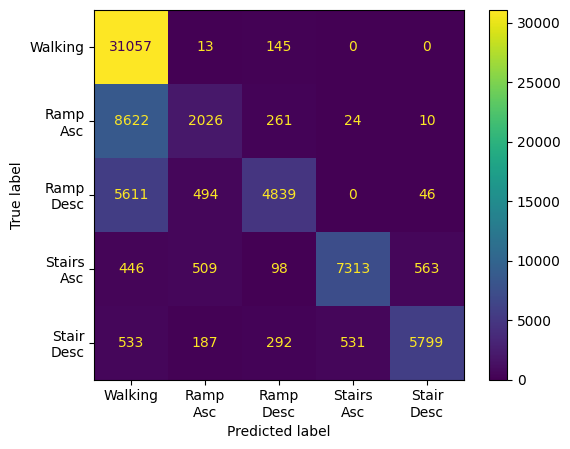

: 

In [30]:
confusion_matrix = metrics.confusion_matrix(np.argmax(val_output_lm, 1), np.argmax(predicted_values, 1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = CLASSES)
cm_display.plot()
plt.show()